In [26]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors
from scipy.signal import resample_poly

scd_data = {'./data/scddb/30': '07:54:33',
 './data/scddb/31': '13:42:24',
 './data/scddb/32': '16:45:18',
 './data/scddb/33': '04:46:19',
 './data/scddb/34': '06:35:44',
 './data/scddb/35': '24:34:56',
 './data/scddb/36': '18:59:01',
 './data/scddb/37': '01:31:13',
 './data/scddb/38': '08:01:54',
 './data/scddb/39': '04:37:51',
 './data/scddb/41': '02:59:24',
 './data/scddb/43': '15:37:11',
 './data/scddb/44': '19:38:45',
 './data/scddb/45': '18:09:17',
 './data/scddb/46': '03:41:47',
 './data/scddb/47': '06:13:01',
 './data/scddb/48': '02:29:40',
 './data/scddb/50': '11:45:43',
 './data/scddb/51': '22:58:23',
 './data/scddb/52': '02:32:40'}
fs=250

In [9]:
def hms_to_seconds(hms):
    h, m, s = hms.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

def extract_before_onset_VF(vfon_dict, minutes_before=30):
    ecg_data_map = {} 

    for record_path, vf_onset_str in vfon_dict.items():
        # record_path might be '.data/scddb/30'
        record_dir, record_name = os.path.split(record_path)

        # 2) Convert dictionary's VF onset to seconds
        vf_onset_original_sec = hms_to_seconds(vf_onset_str)

        vfon_onset_original_sample = vf_onset_original_sec * fs

        seg_len_samples = int(minutes_before * 60 * fs)

        start_sample = vfon_onset_original_sample - seg_len_samples

         # read .dat between those sample indices
        try:
            #record_dat_path = os.path.join(record_dir, record_name)  # base path
            record_path_dat = os.path.join(record_dir, record_name)
            segment = wfdb.rdrecord(record_path_dat, sampfrom=start_sample, sampto=vfon_onset_original_sample)
            
        except Exception as e:
            print(f"[ERROR] Failed to read record {record_dat_path}: {e}")
            continue

        # Retrieve the raw signal data as a NumPy array
        if segment.p_signal is not None:
            arr = segment.p_signal[:,0]
            ecg_data_map[record_name] = arr
            print(f"[OK] Extracted 30-min for {record_name}: shape={arr.shape}")
        else:
            print(f"[WARNING] No p_signal found for {record_name}")

    return ecg_data_map

def segment_ecg(ecg_segment, segment_duration_sec=300, fs=250):
    samples_per_segment = segment_duration_sec * fs
    segments = np.array_split(ecg_segment, len(ecg_segment) // samples_per_segment)
    return segments

In [11]:
onsetVF_30min_scd = extract_before_onset_VF(scd_data, minutes_before=30)
onset30_6segments_5mins = segment_ecg(onsetVF_30min_scd['30'])
first_5min_of30 = onset30_6segments_5mins[5]

[OK] Extracted 30-min for 30: shape=(450000,)
[OK] Extracted 30-min for 31: shape=(450000,)
[OK] Extracted 30-min for 32: shape=(450000,)
[OK] Extracted 30-min for 33: shape=(450000,)
[OK] Extracted 30-min for 34: shape=(450000,)
[OK] Extracted 30-min for 35: shape=(450000,)
[OK] Extracted 30-min for 36: shape=(450000,)
[OK] Extracted 30-min for 37: shape=(450000,)
[OK] Extracted 30-min for 38: shape=(450000,)
[OK] Extracted 30-min for 39: shape=(450000,)
[OK] Extracted 30-min for 41: shape=(450000,)
[OK] Extracted 30-min for 43: shape=(450000,)
[OK] Extracted 30-min for 44: shape=(450000,)
[OK] Extracted 30-min for 45: shape=(450000,)
[OK] Extracted 30-min for 46: shape=(450000,)
[OK] Extracted 30-min for 47: shape=(450000,)
[OK] Extracted 30-min for 48: shape=(450000,)
[OK] Extracted 30-min for 50: shape=(450000,)
[OK] Extracted 30-min for 51: shape=(450000,)
[OK] Extracted 30-min for 52: shape=(450000,)


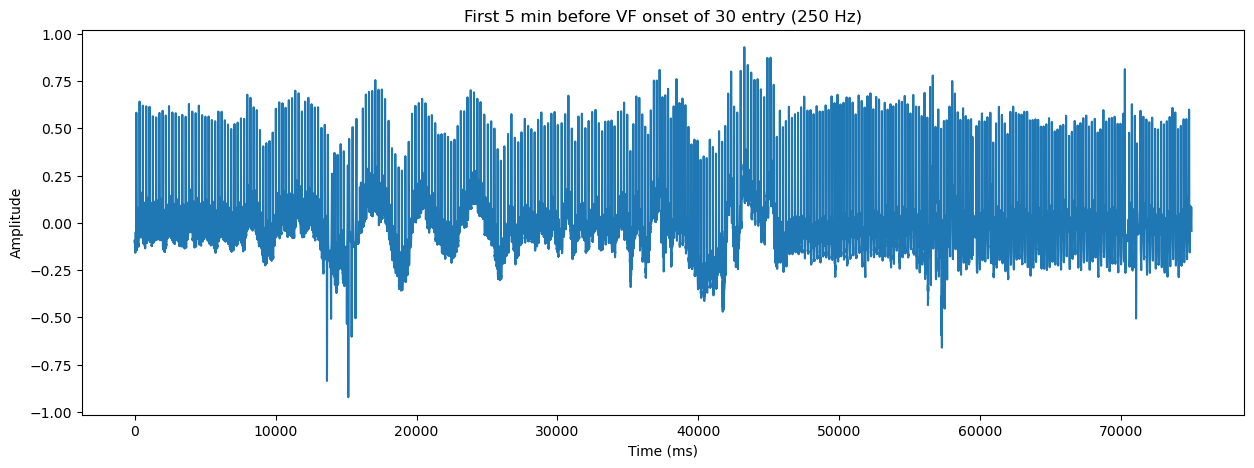

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(first_5min_of30)
plt.title('First 5 min before VF onset of 30 entry (250 Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

# Downsample

In [18]:
def resample_ecg(ecg_signal, orig_fs, target_fs):
    """
    Resample ECG signal from orig_fs to target_fs using polyphase filtering.
    ecg_signal: 1D (or 2D) numpy array (samples x channels)
    """
    # For example, if orig_fs=250, target_fs=128:
    # up = 128, down = 250
    up = target_fs
    down = orig_fs

    if ecg_signal.ndim == 1:
        ecg_resampled = resample_poly(ecg_signal, up, down)
    else:
        # If multi-channel, resample each column
        ecg_resampled = np.array([
            resample_poly(ecg_signal[:, ch], up, down) 
            for ch in range(ecg_signal.shape[1])
        ]).T

    return ecg_resampled

In [20]:
first_5min_of30.shape

(75000,)

In [22]:
first_5min_of30

array([-0.0975 , -0.09125, -0.09875, ..., -0.03625, -0.03875, -0.0425 ])

In [32]:
# downsampling 250 -> 128
ecg_downsampled_250_to_128 = resample_ecg(first_5min_of30, 250, 128)

In [34]:
ecg_downsampled_250_to_128.shape

(38400,)

In [36]:
ecg_downsampled_250_to_128

array([-0.0715235 , -0.10325322, -0.09964019, ..., -0.03350907,
       -0.03113093, -0.04236117])

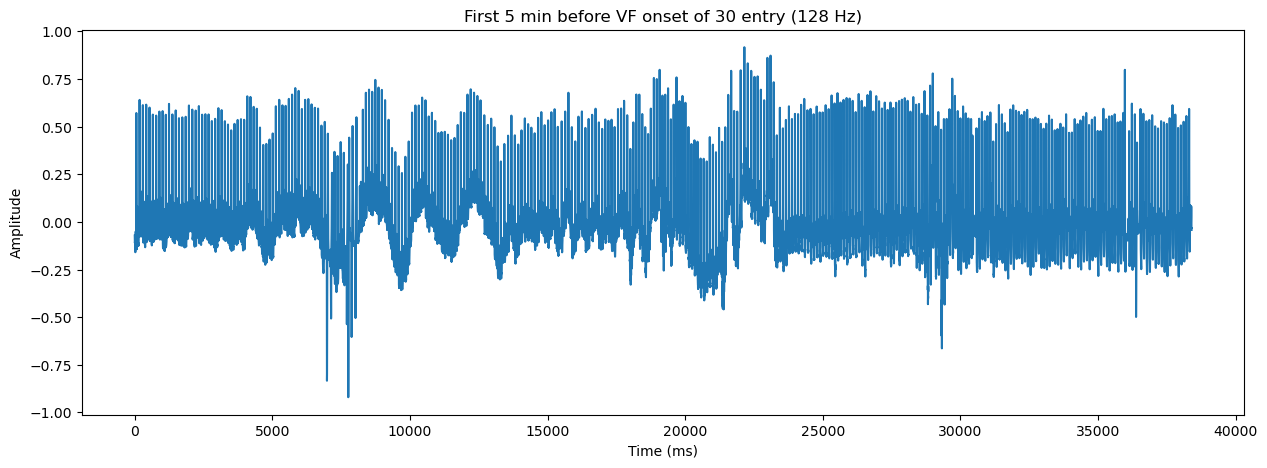

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(ecg_downsampled_250_to_128)
plt.title('First 5 min before VF onset of 30 entry (128 Hz)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

# denoise

In [45]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = pywt.wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  

## Rbio fam waves

In [61]:
rb = ['rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8']

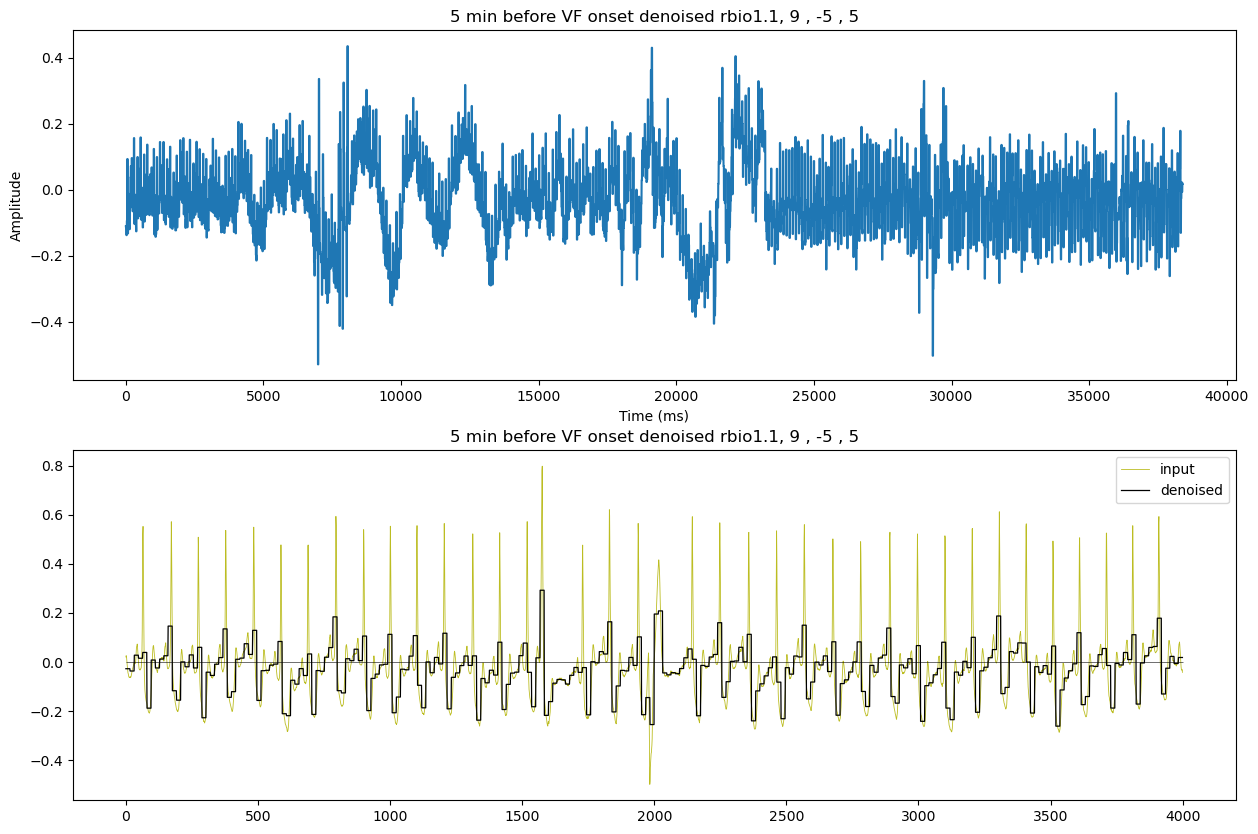

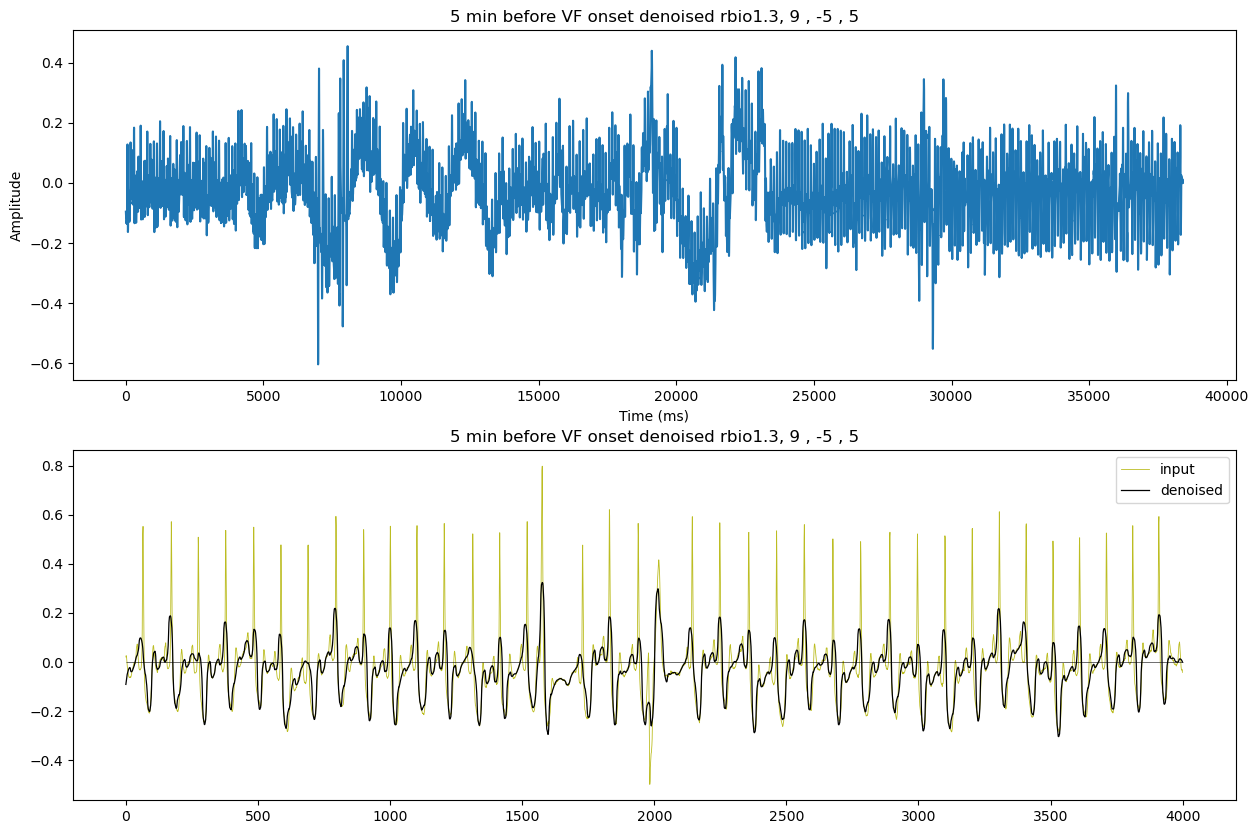

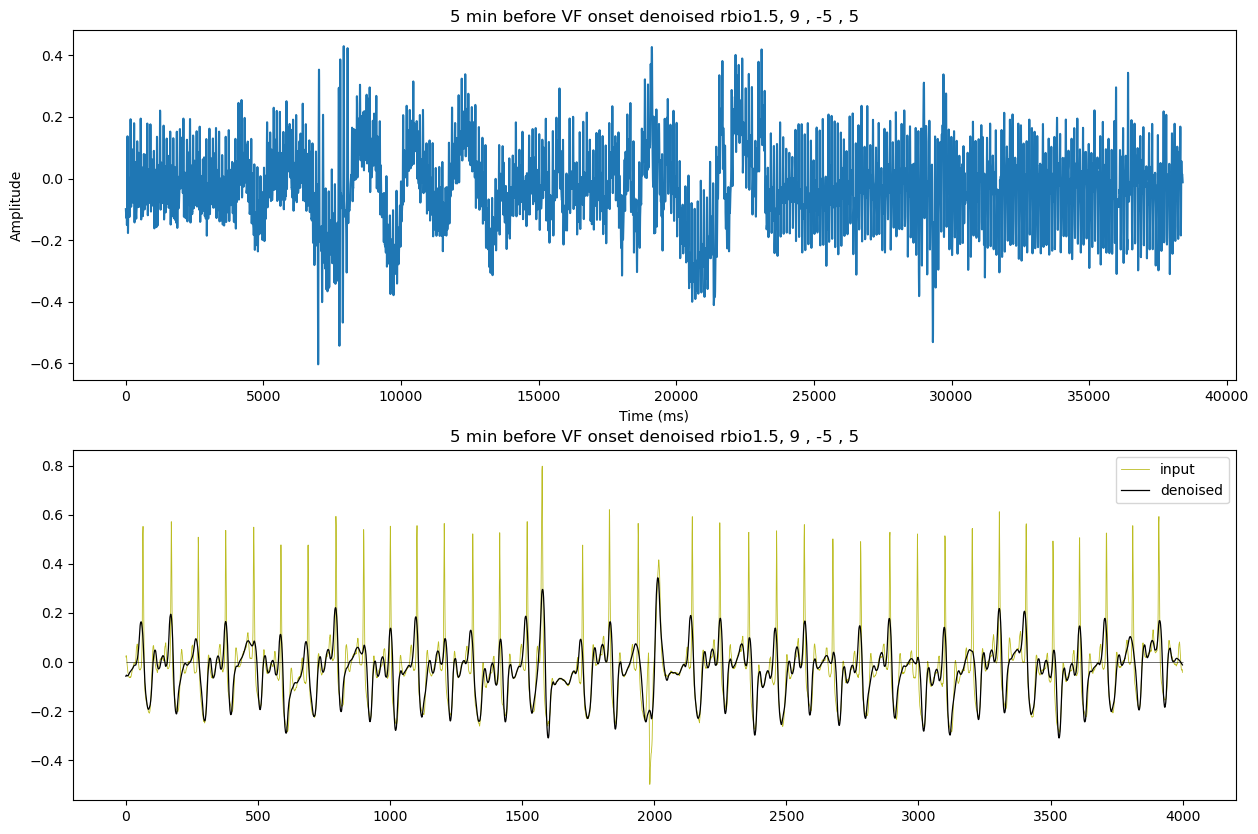

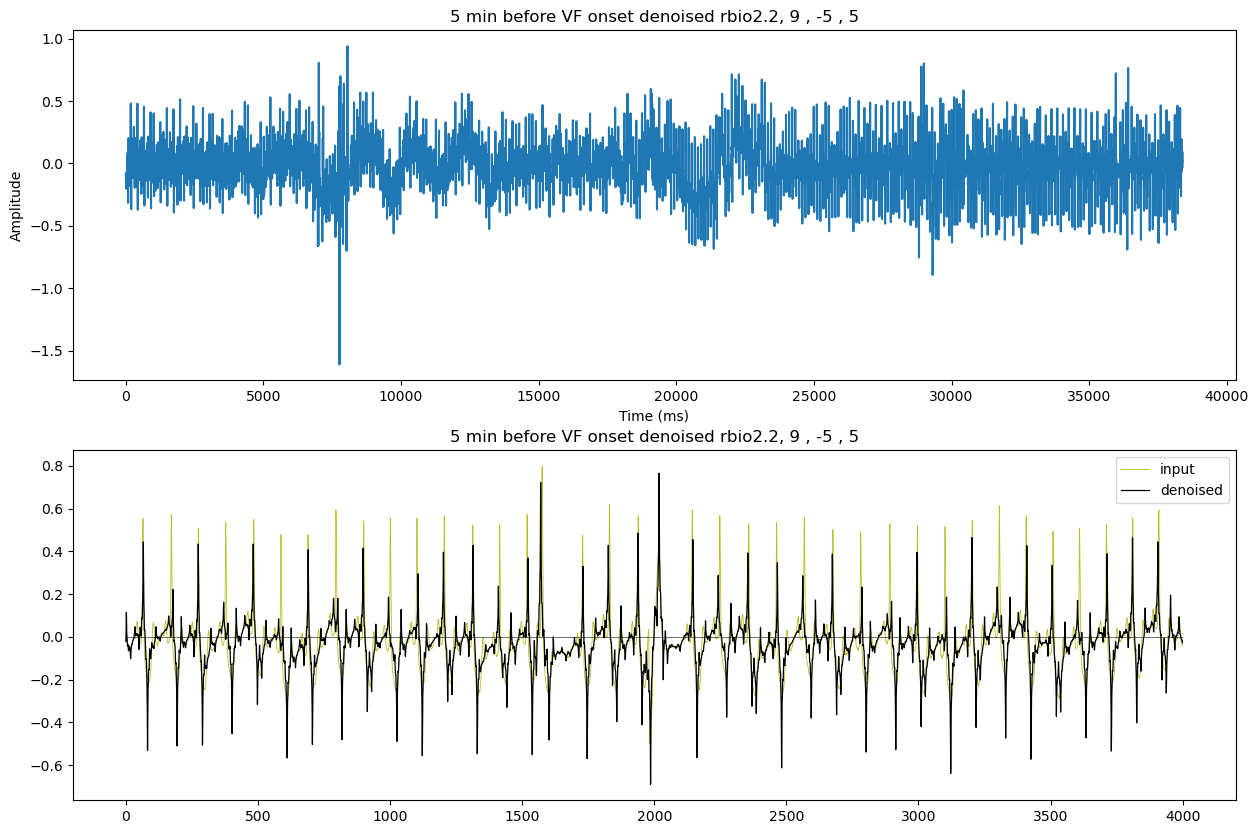

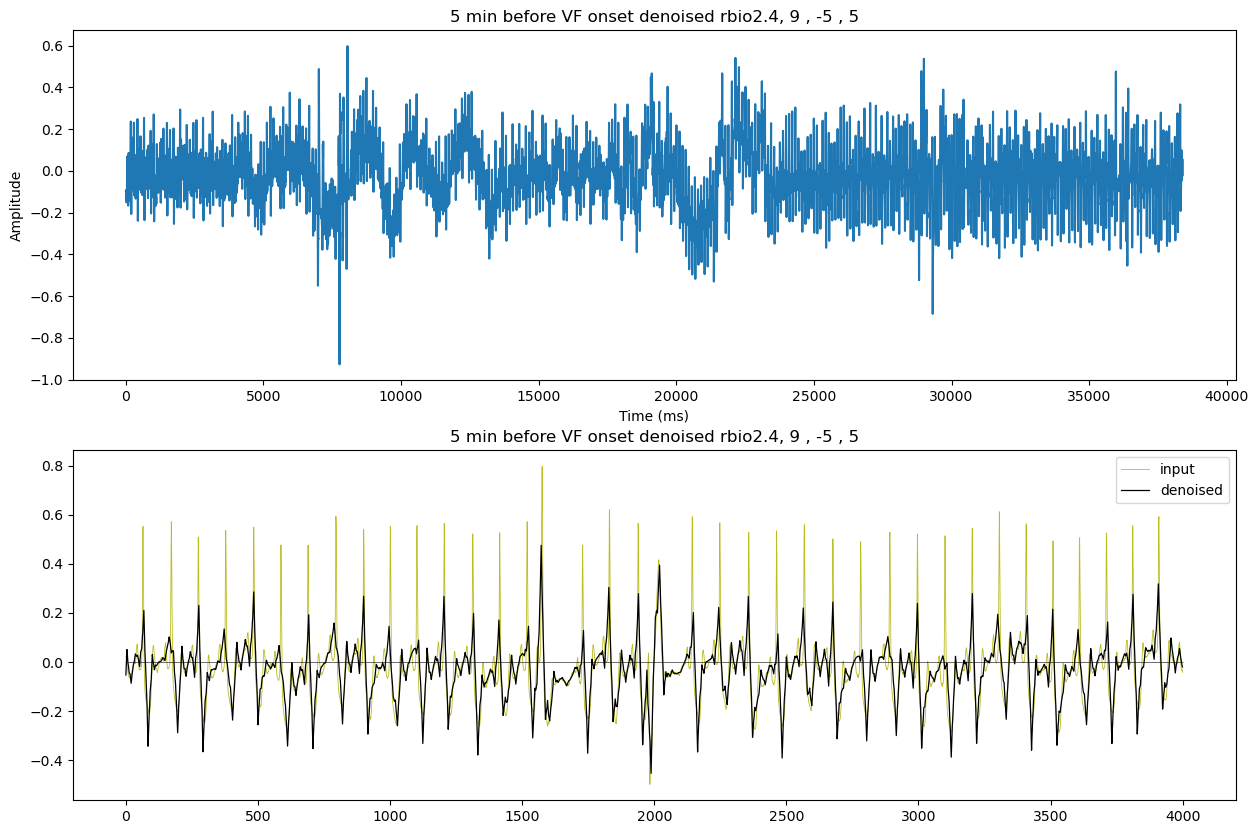

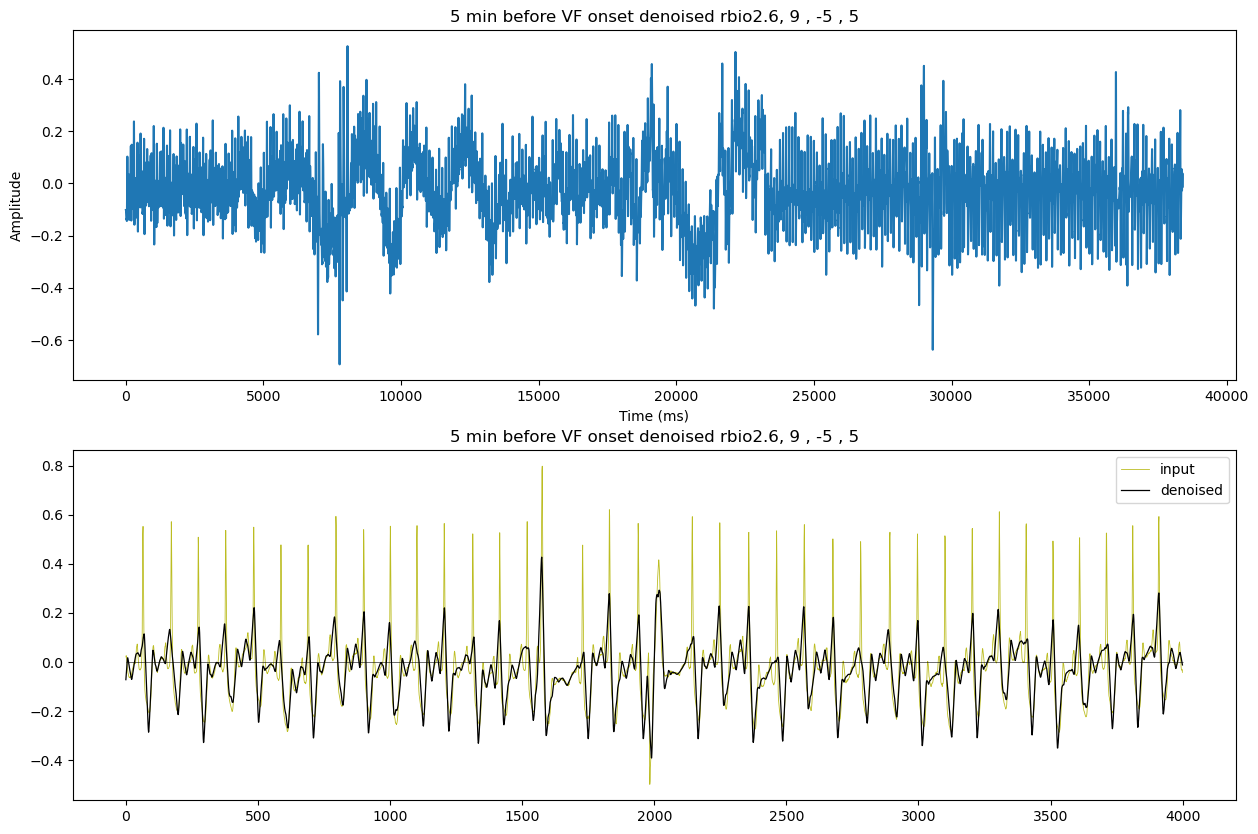

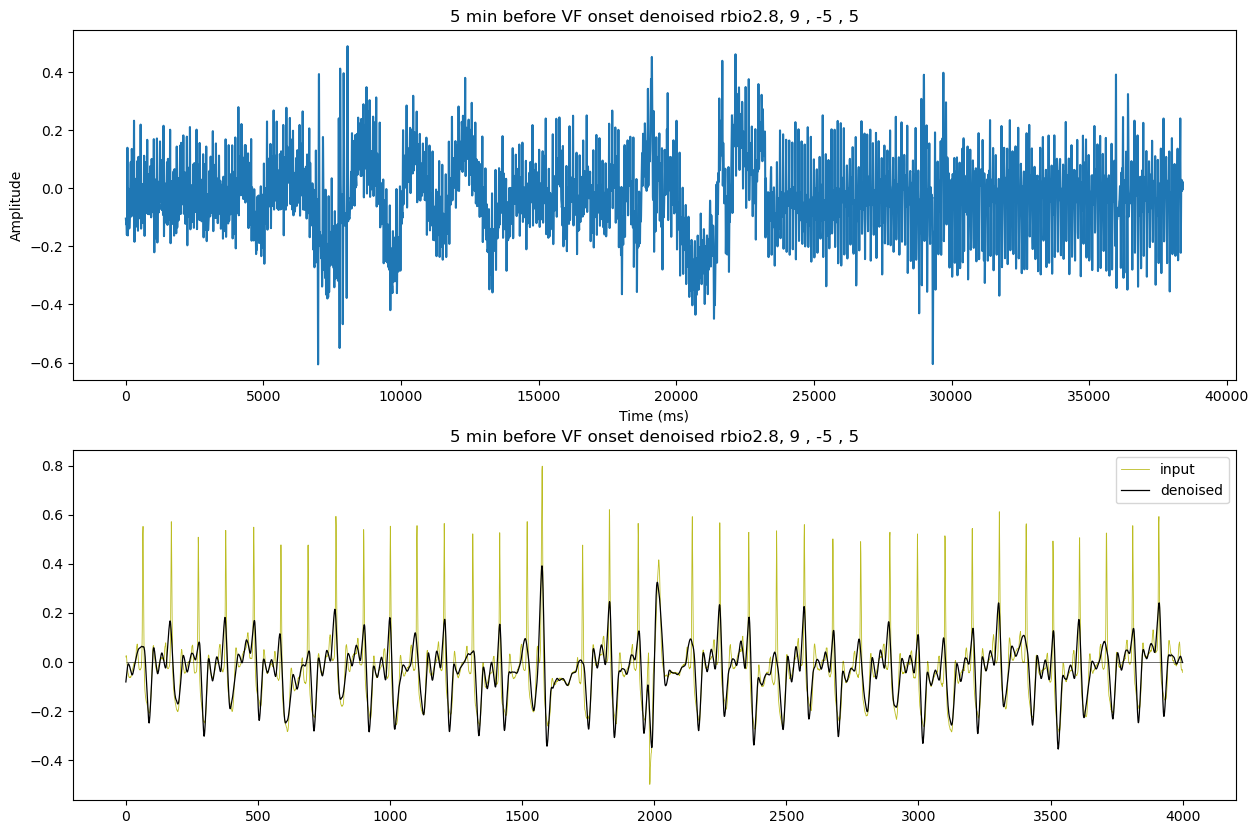

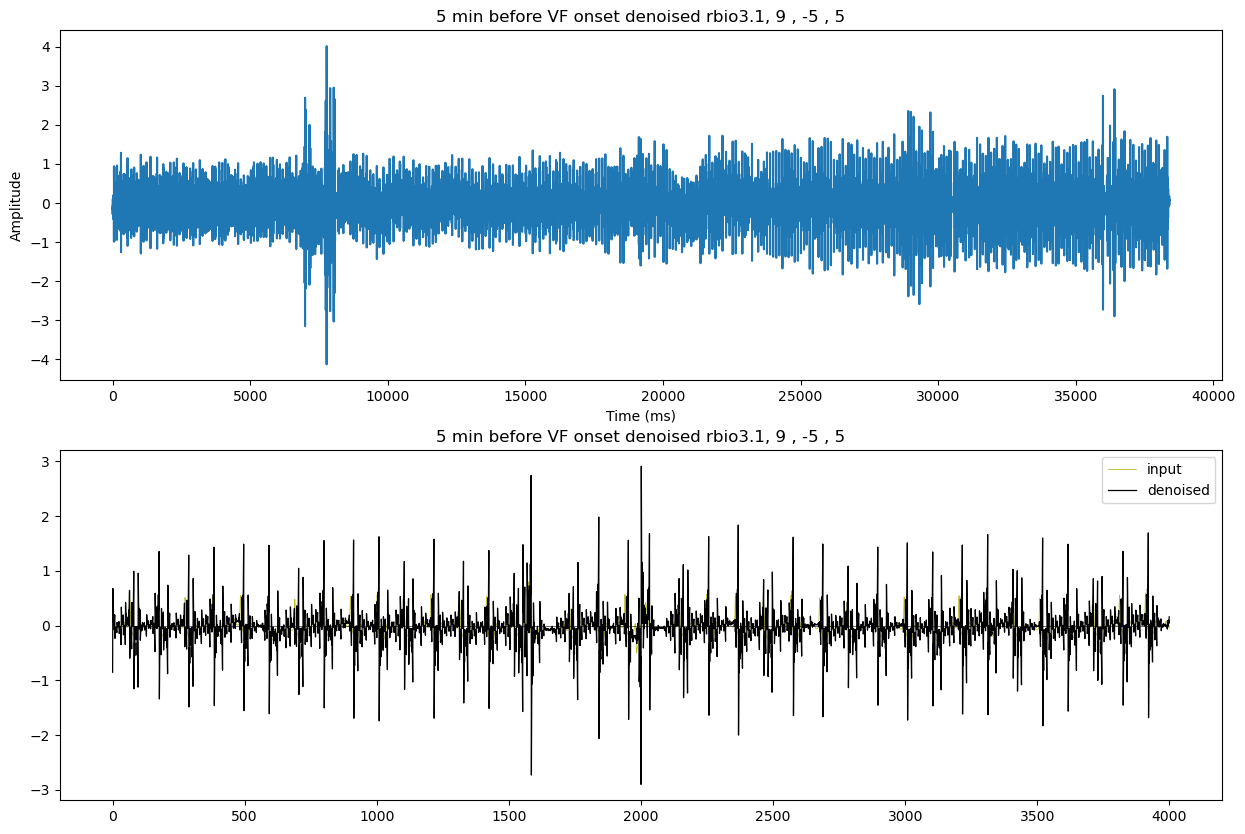

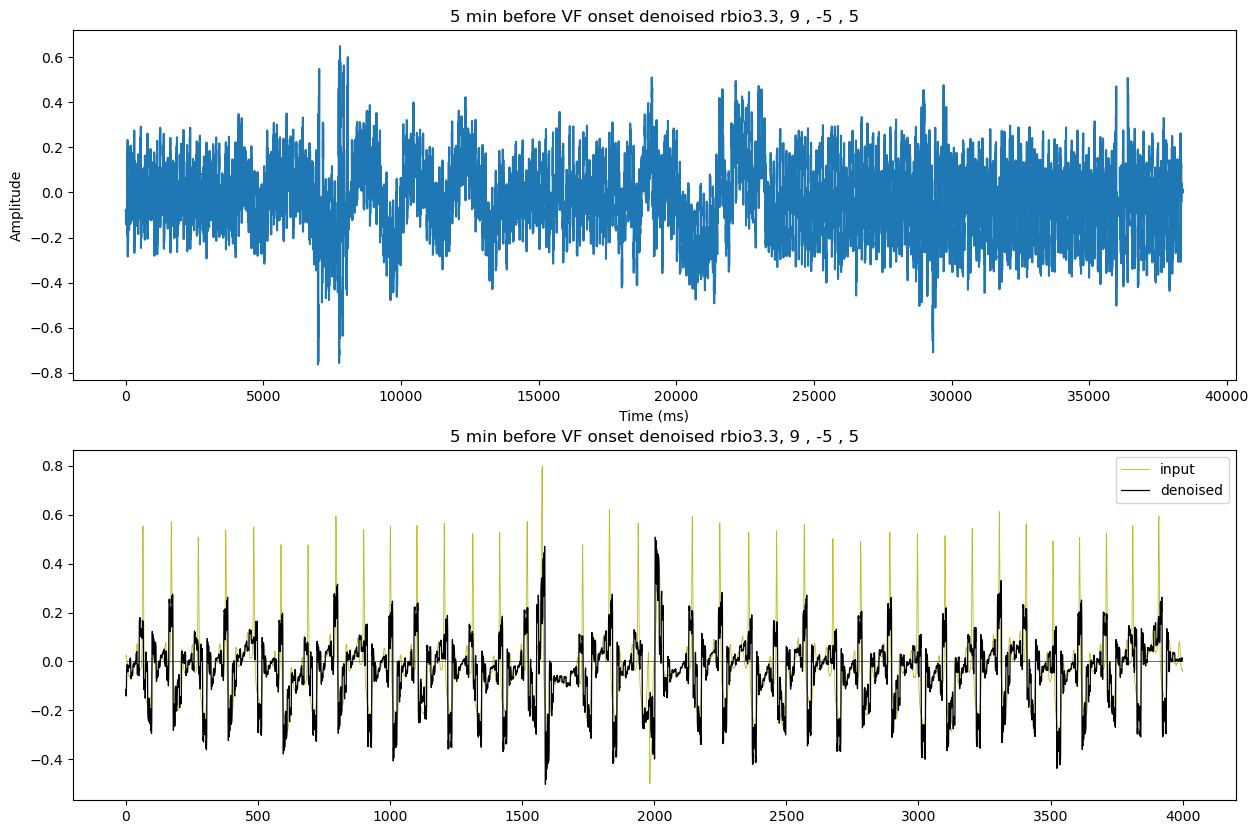

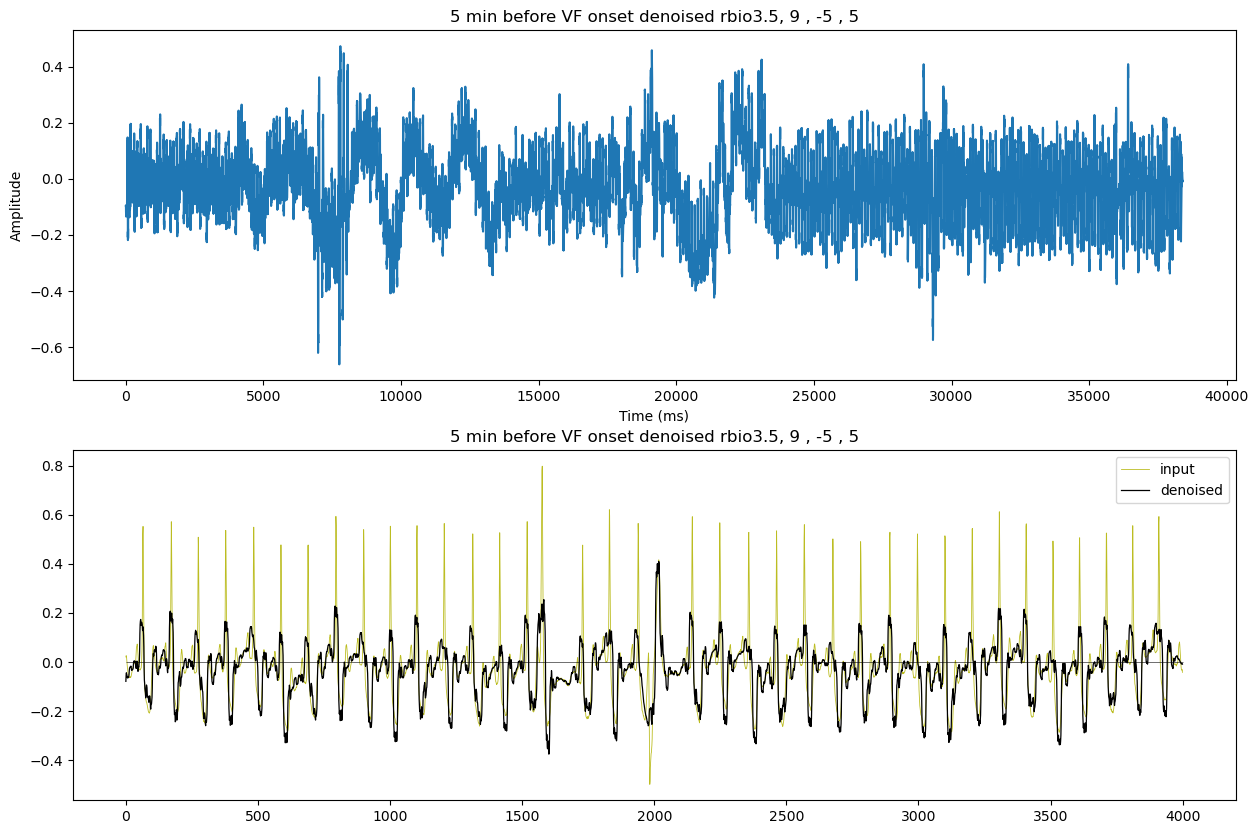

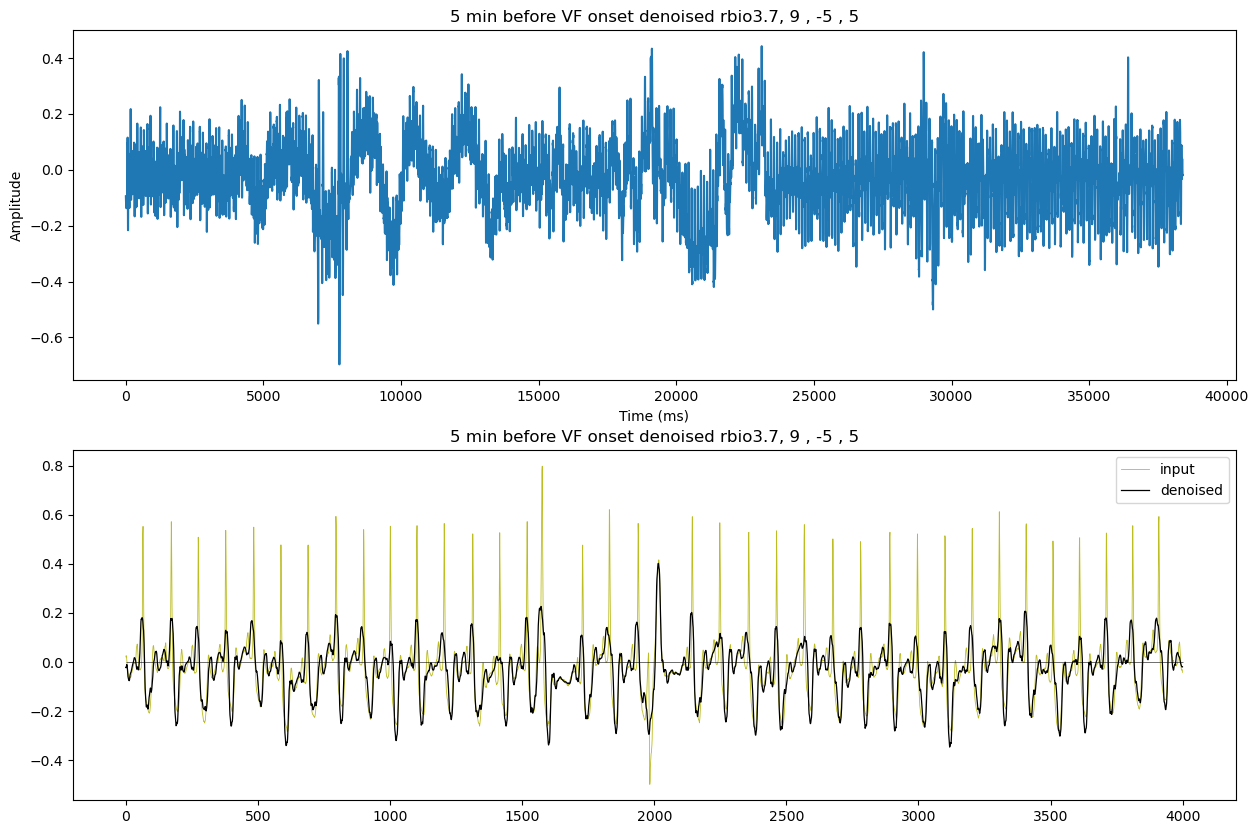

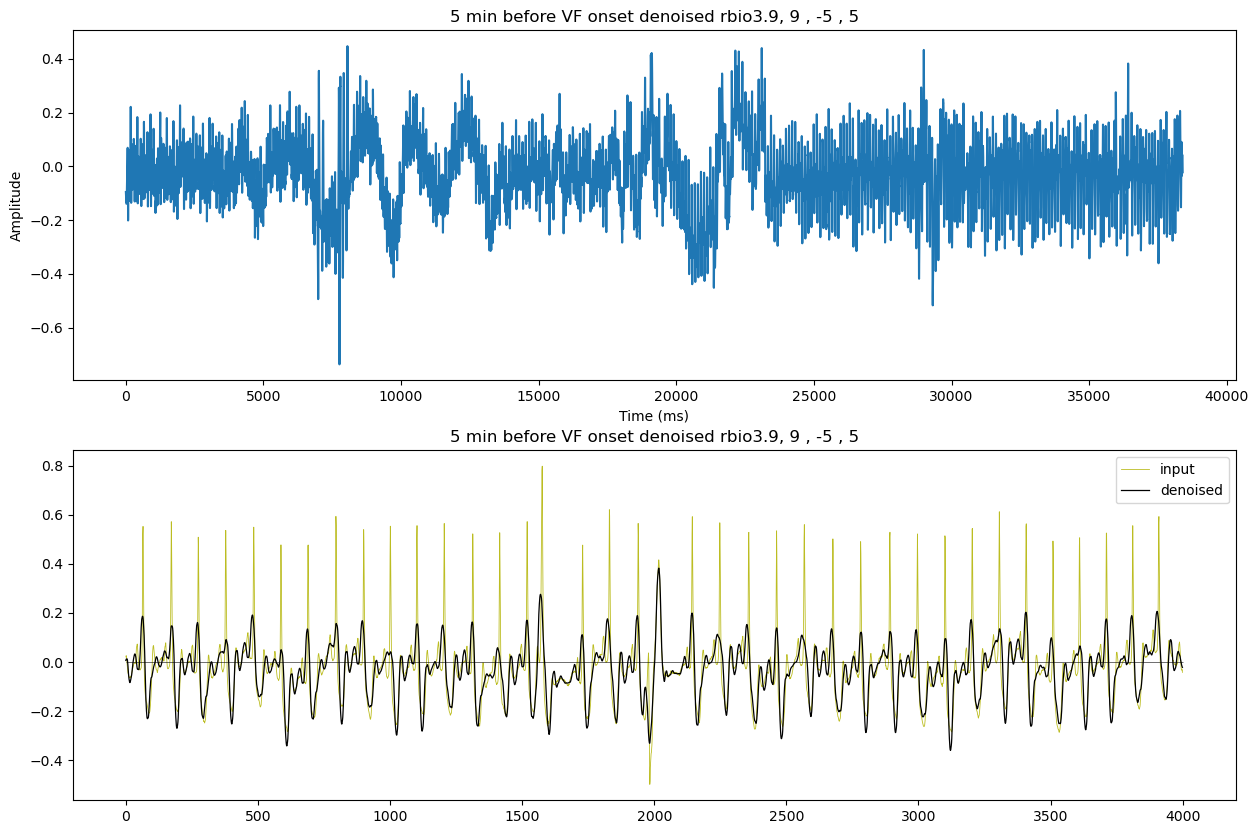

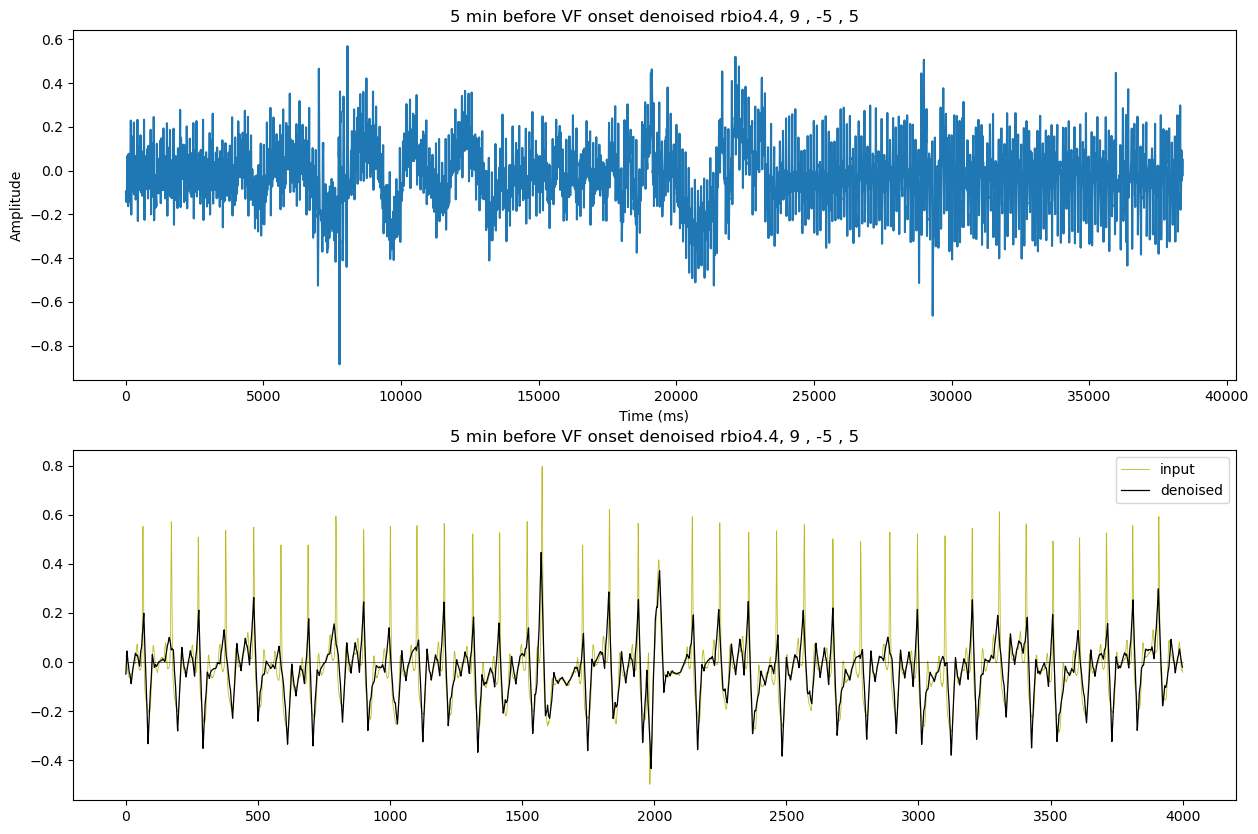

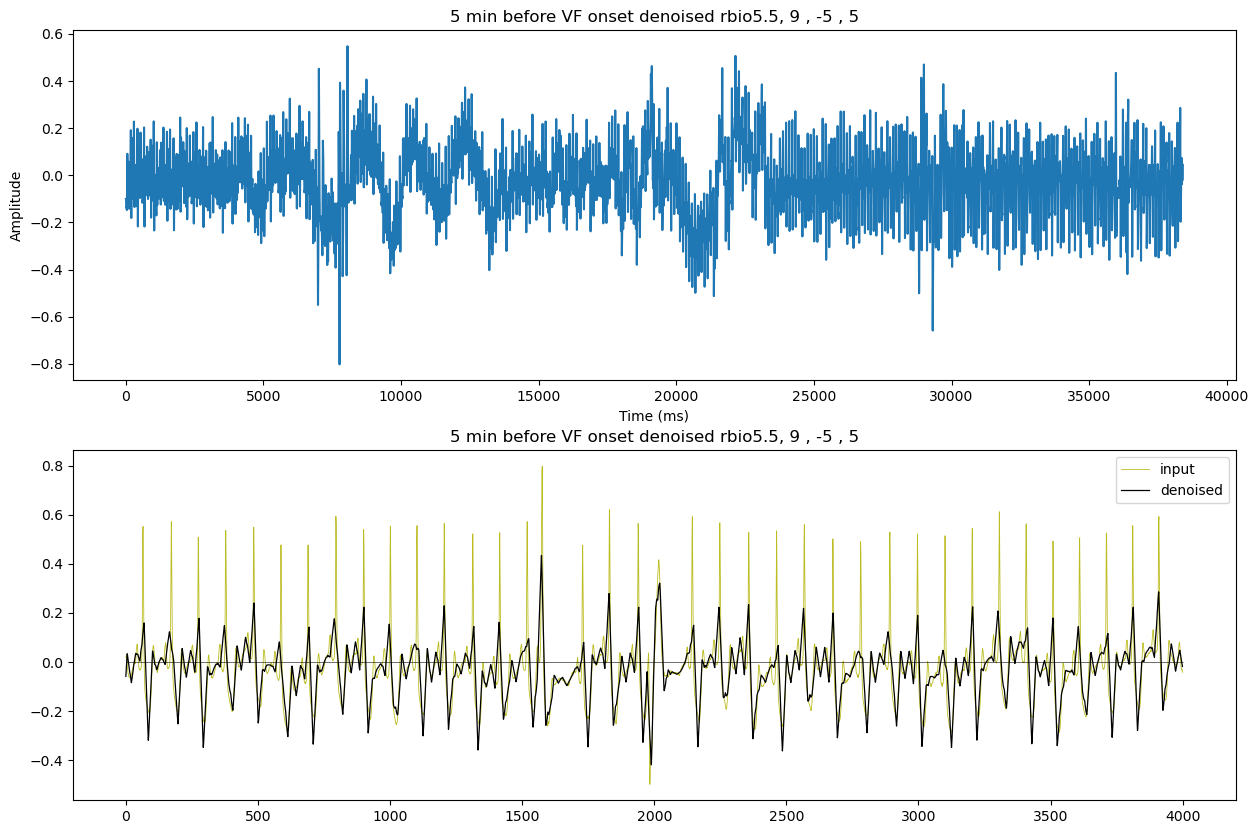

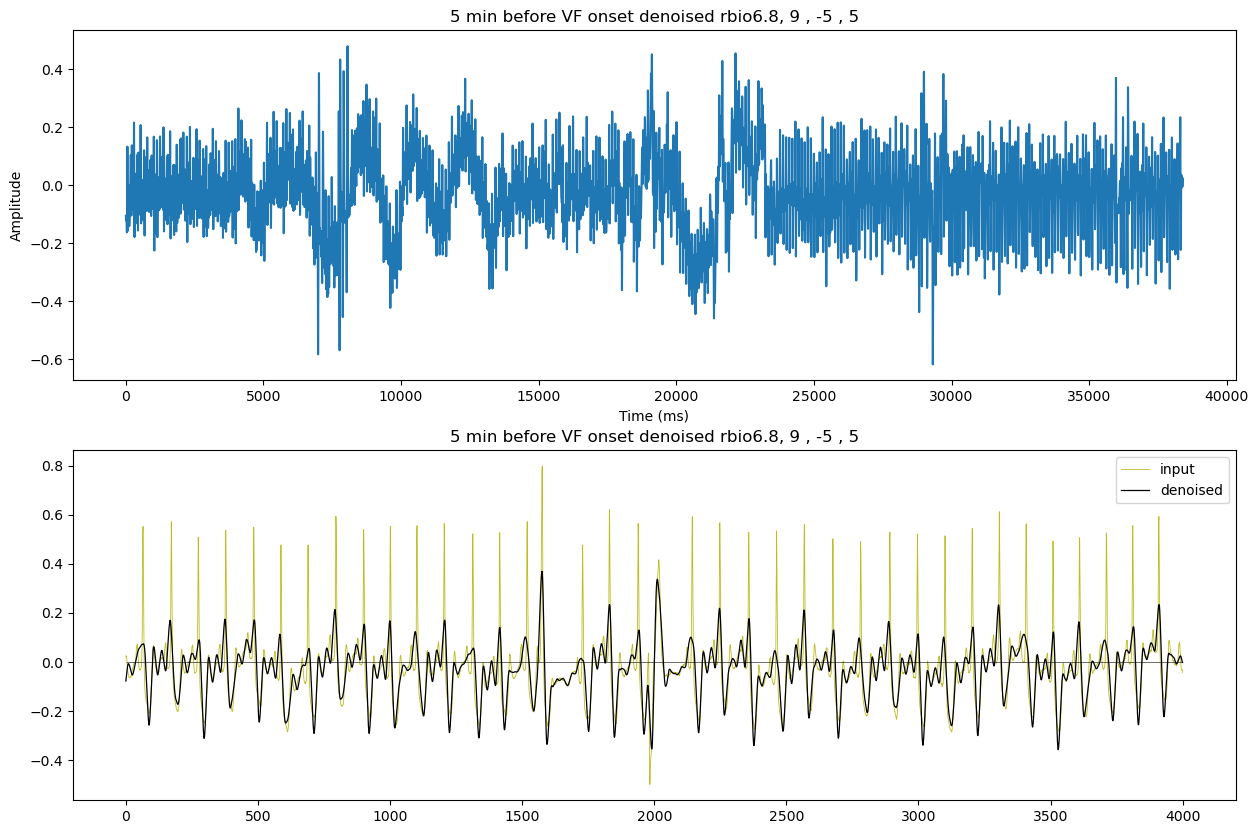

In [67]:
for i in range(len(rb)):
    scd_30_denoised_ex = denoise_signal(ecg_downsampled_250_to_128, rb[i], 8 , -5 , 5)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(scd_30_denoised_ex)
    plt.title(f'5 min before VF onset denoised {rb[i]}, 9 , -5 , 5')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    plt.plot(ecg_downsampled_250_to_128[-4000:], color='tab:olive', linewidth=0.6,label = 'input')
    plt.title(f'5 min before VF onset denoised {rb[i]}, 9 , -5 , 5')
    plt.plot(scd_30_denoised_ex[-4000:], color='black', linewidth=0.9,label = 'denoised')
    plt.hlines(0,0,4000,color='black', linewidth=0.4)
    plt.legend()
    plt.show()

### RBIO 6.8

In [70]:
scd_30_128HZ_denoised_rbio6_8 = denoise_signal(ecg_downsampled_250_to_128, 'rbio6.8', 8 , -5 , 5)

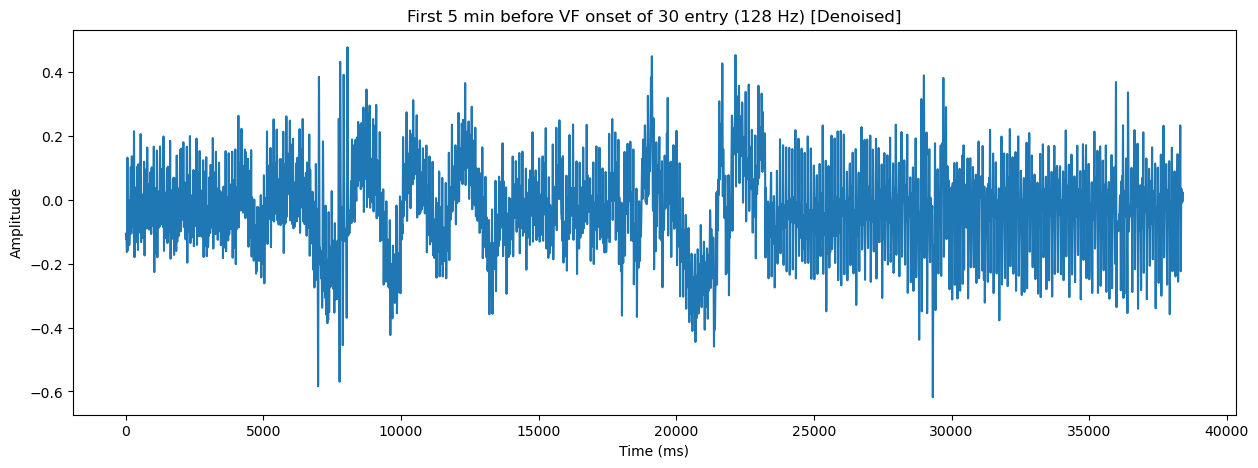

In [75]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(scd_30_128HZ_denoised_rbio6_8)
plt.title('First 5 min before VF onset of 30 entry (128 Hz) [Denoised]')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

# R peak detect

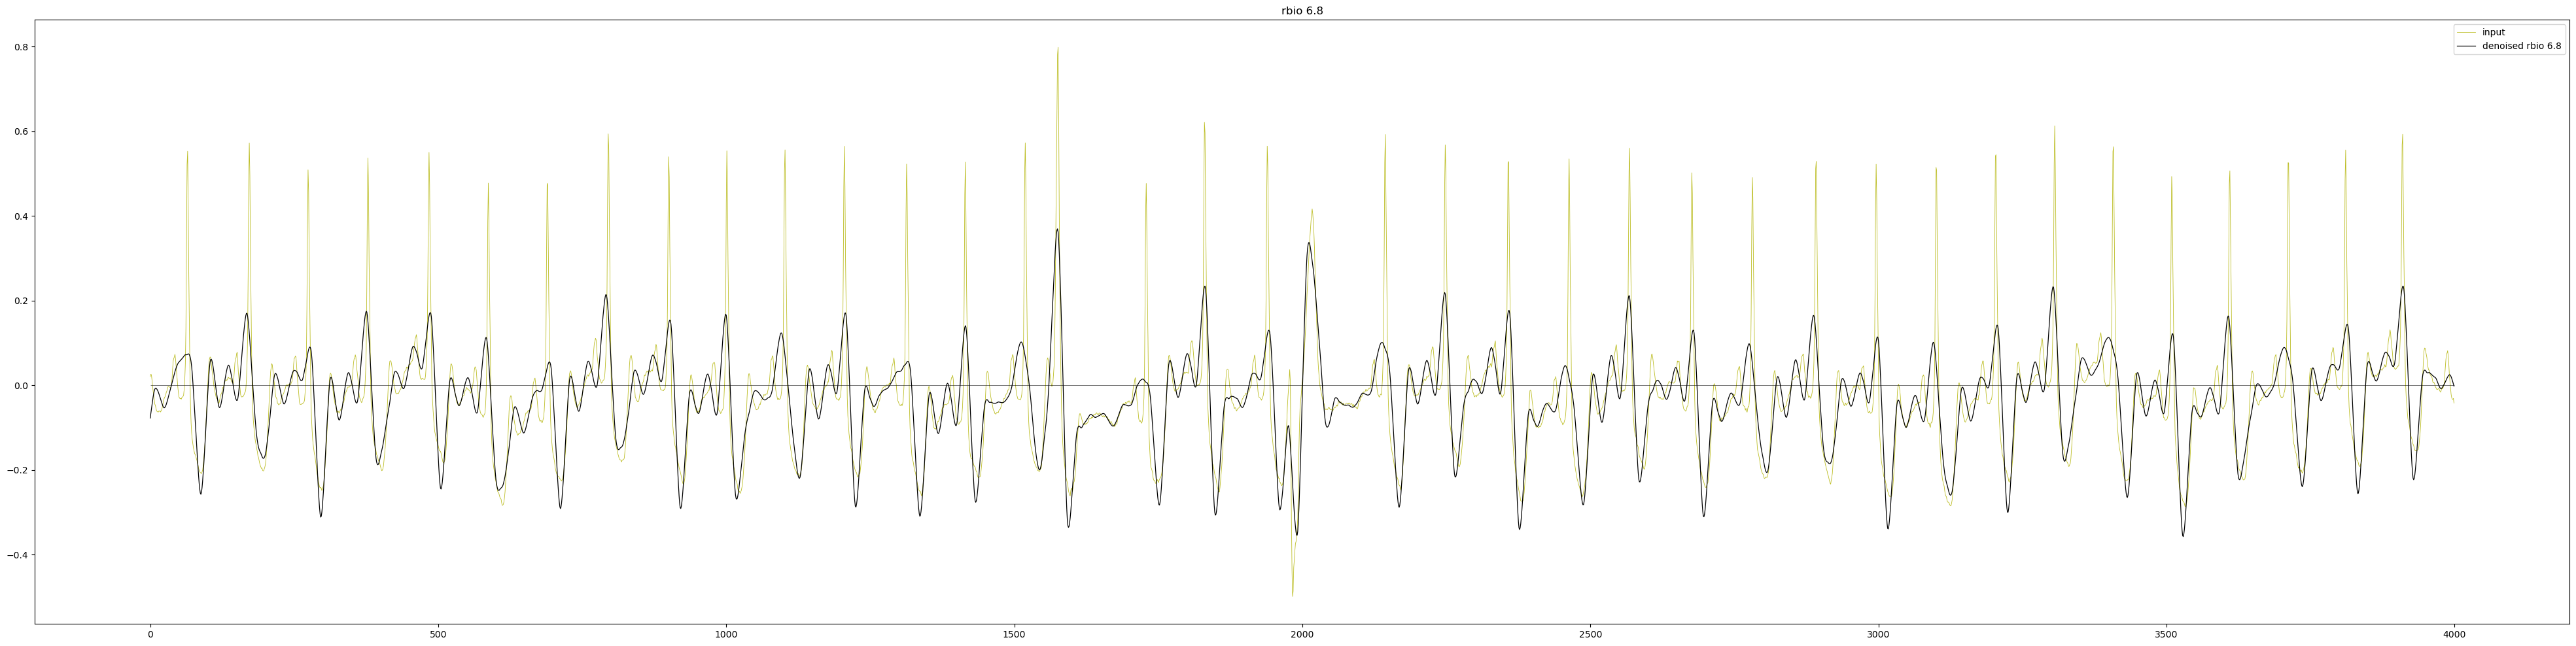

In [79]:
plt.figure(figsize=(50,12))

plt.plot(ecg_downsampled_250_to_128[-4000:], color='tab:olive', linewidth=0.6,label = 'input')
plt.plot(scd_30_128HZ_denoised_rbio6_8[-4000:], color='black', linewidth=0.9,label = 'denoised rbio 6.8')
plt.title('rbio 6.8')
plt.hlines(0,0,4000,color='black', linewidth=0.4)
plt.legend()

In [91]:
BASIC_SRATE = 128
signal_pad_samples = 10
signal_pad = np.zeros(signal_pad_samples) # pad one sec to detect initial peaks properly
detectors = Detectors(BASIC_SRATE)
detectors = {
            'pan_tompkins_detector':[detectors.pan_tompkins_detector, []],
            'hamilton_detector':[detectors.hamilton_detector, []],
            'christov_detector':[detectors.christov_detector, []],
            'engzee_detector':[detectors.engzee_detector, []],
            'swt_detector':[detectors.swt_detector, []],
            'two_average_detector':[detectors.two_average_detector, []],
            }

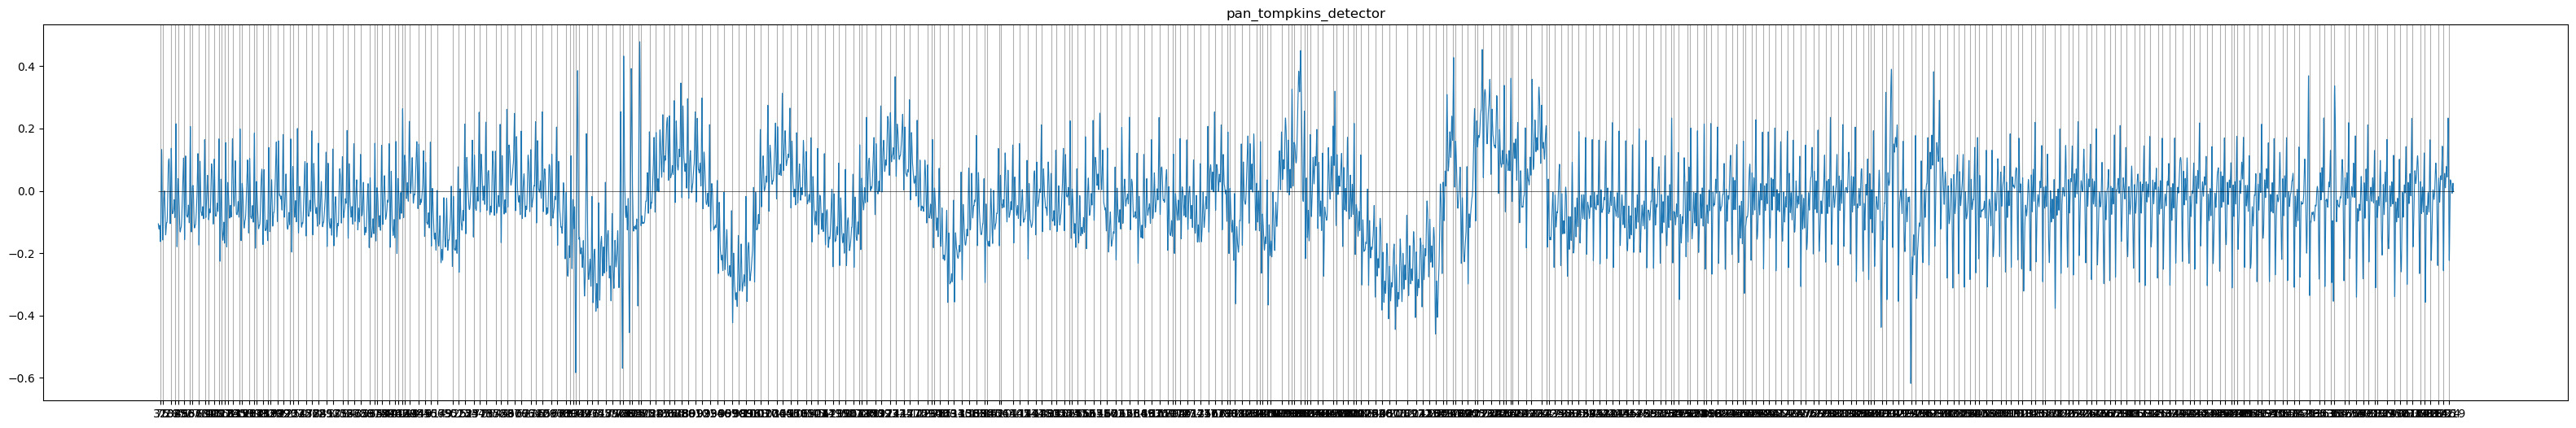

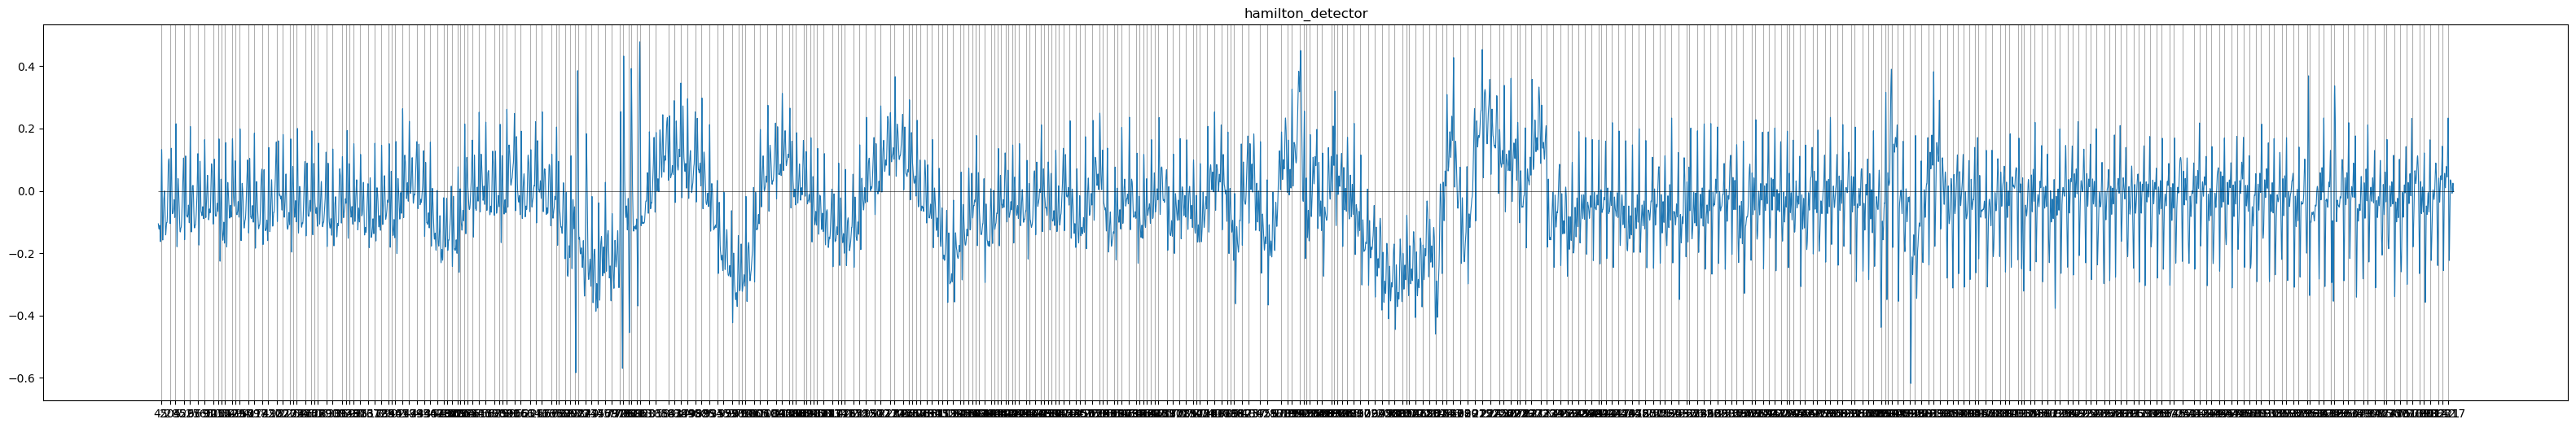

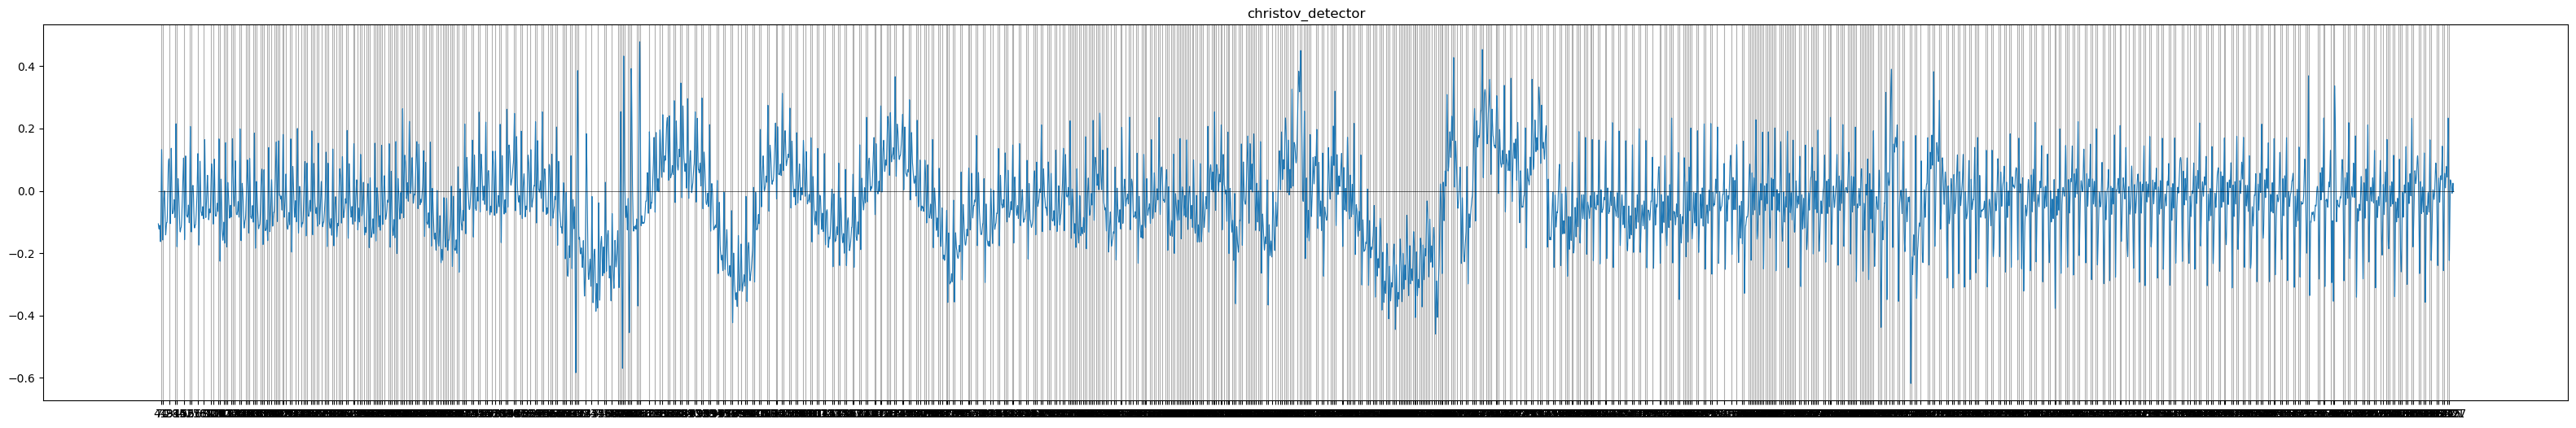

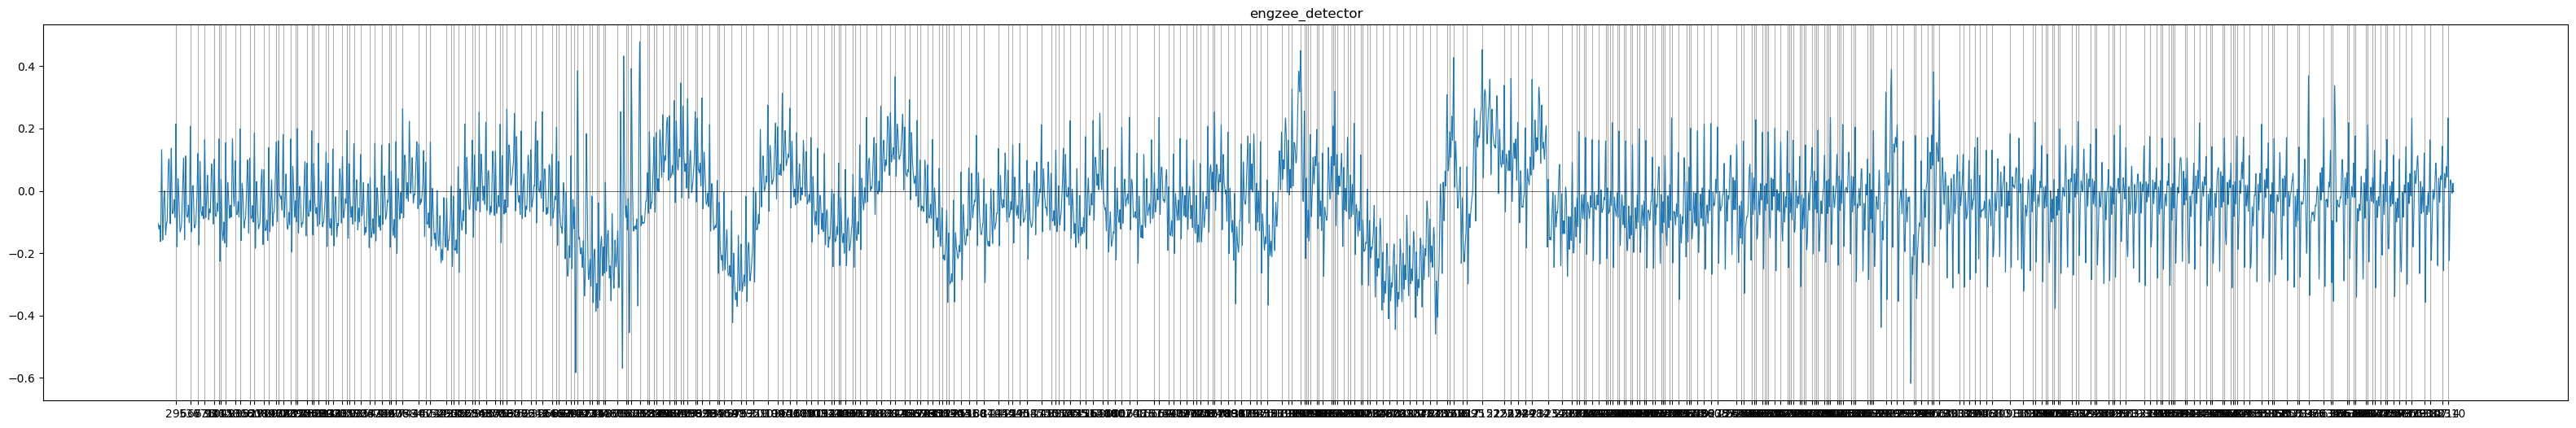

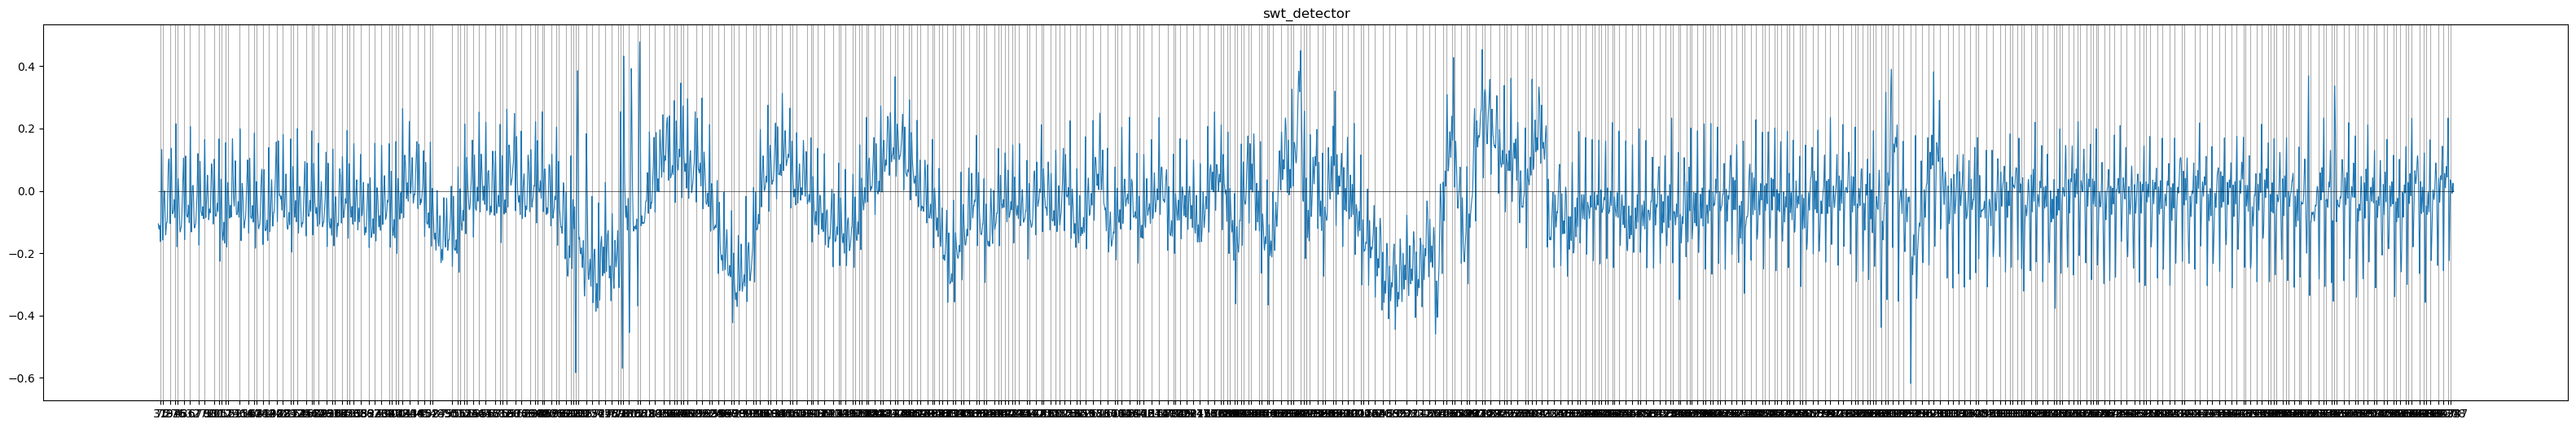

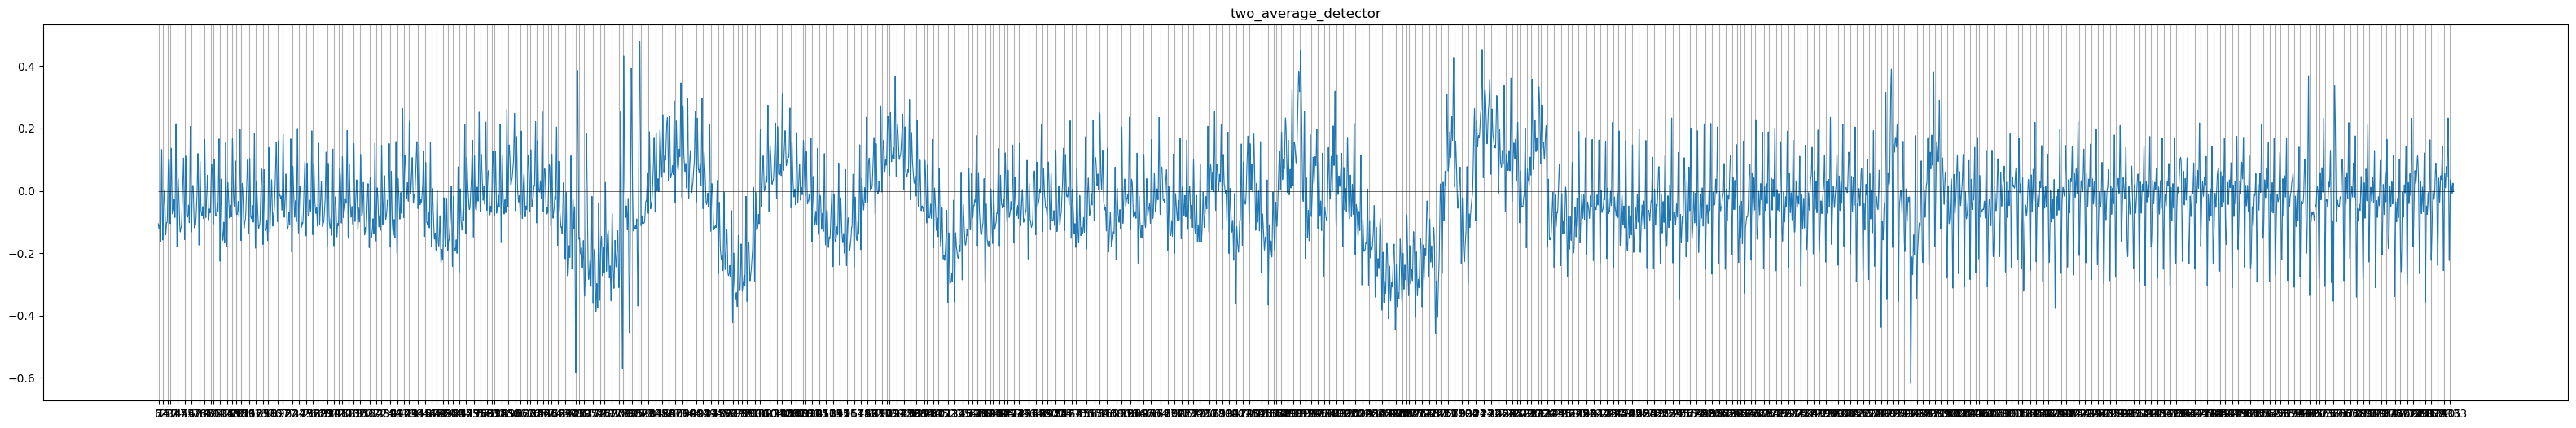

In [94]:
scd_30_128HZ_denoised_rbio6_8_r_peak = scd_30_128HZ_denoised_rbio6_8

for kd in detectors.keys():
    vd = detectors[kd]
    r_peaks = np.array(vd[0](np.hstack((signal_pad,scd_30_128HZ_denoised_rbio6_8_r_peak)))) - signal_pad_samples
    vd[1] = r_peaks
    plt.figure(figsize=(40,6))
    plt.title(kd)
    plt.plot(scd_30_128HZ_denoised_rbio6_8_r_peak,color='tab:blue',linewidth=0.8)
    plt.hlines(0,0,38400,color='black', linewidth=0.4)
    plt.xticks(r_peaks)
    plt.grid(axis='x')
    plt.show()

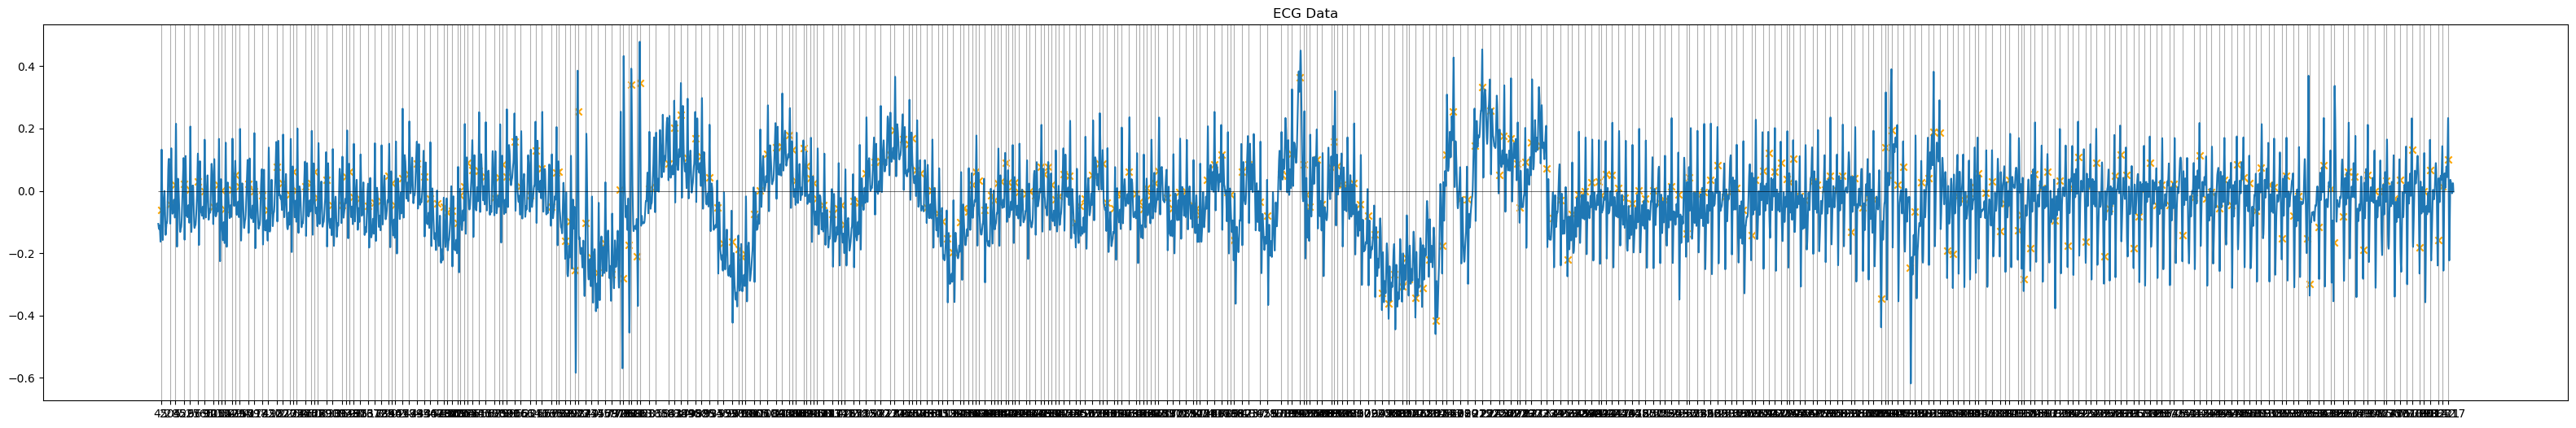

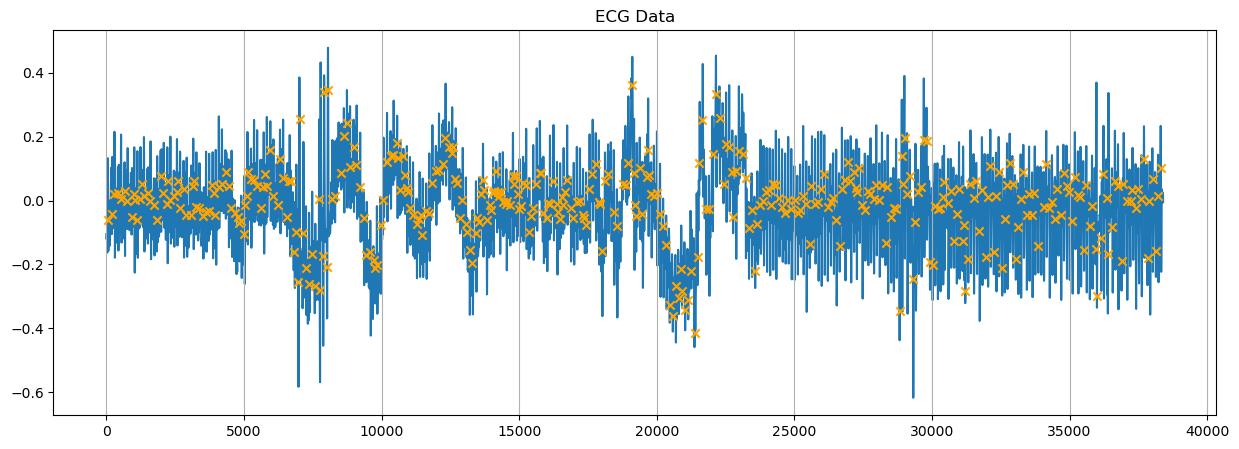

In [96]:
data_signal_rbio6_8 = scd_30_128HZ_denoised_rbio6_8_r_peak
data_peaks_rbio6_8_hamilton = detectors['hamilton_detector'][1]
segments = scd_30_128HZ_denoised_rbio6_8_r_peak

plt.figure(figsize=(40,6))
plt.title('ECG Data')
plt.plot(segments)
plt.scatter(data_peaks_rbio6_8_hamilton, data_signal_rbio6_8[data_peaks_rbio6_8_hamilton], color='orange', marker='x', label='R-peaks')
plt.hlines(0,0,38400,color='black', linewidth=0.4)
plt.xticks(data_peaks_rbio6_8_hamilton)
plt.grid(axis='x')
plt.show()

plt.figure(figsize=(15,5))
plt.title('ECG Data')
plt.scatter(data_peaks_rbio6_8_hamilton, data_signal_rbio6_8[data_peaks_rbio6_8_hamilton], color='orange', marker='x', label='R-peaks', zorder=2)
plt.plot(segments, zorder=1)
plt.grid(axis='x')
plt.show()